In [37]:
import osmnx as ox
import networkx as nx
import numpy as np
import pandas as pd
import random
import time
from IPython.display import Image
%matplotlib inline

In [2]:
###OSHAWA/WHITBY 
#East/North
# 43.984503, -78.821660
#West/South
# 43.862879, -78.934552

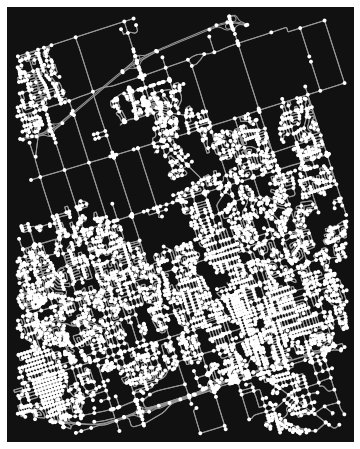

(<Figure size 576x576 with 1 Axes>, <AxesSubplot:>)

In [102]:
# Defining the map boundaries 
north, east, south, west = 43.984503, -78.821660, 43.862879, -78.954552
# Downloading the map as a graph object 
G = ox.graph_from_bbox(north, south, east, west, network_type = 'drive') 
# Plotting the map graph 
ox.plot_graph(G)#, bgcolor='white', edge_color='blue', node_color='black')

In [4]:
G.nodes

NodeView((699620, 700843, 701384, 701405, 702725, 702764, 702783, 702786, 702787, 702792, 702793, 702796, 702798, 702804, 702840, 702841, 702850, 702865, 702871, 702874, 702881, 1503110, 1503112, 1503211, 1503218, 1503247, 3445618, 3455080, 21488876, 81704716, 82815089, 82815094, 82815096, 82815105, 82815106, 82815113, 82815115, 82815119, 82815125, 82826533, 82826536, 82826546, 82826550, 82826555, 84051976, 84068300, 84068301, 84068302, 85196786, 85196787, 85196788, 85203478, 85203482, 85203483, 95310792, 95312807, 95316567, 95317114, 95317116, 95317118, 95321196, 95321201, 96778147, 96778148, 96778150, 96778154, 96780932, 96780949, 96780951, 96781913, 96781914, 96782153, 96782155, 96782156, 96782289, 96782291, 96782427, 96782428, 96782632, 96783116, 96783537, 96783538, 96783539, 96783786, 96783981, 96783990, 96784478, 96785581, 96785583, 124789911, 124789913, 124789925, 249970907, 249970947, 249970996, 249971089, 266593039, 266593062, 277964883, 277965813, 277965814, 277965818, 277966

In [5]:
# Check the number of nodes in this graph
num_nodes = len(G.nodes)
num_nodes

4417

In [6]:
# Check the number of edges in this graph
len(G.edges)

12013

In [7]:
# Define a starting point
# My house

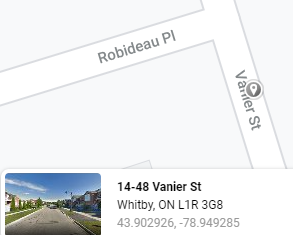

In [39]:
Image(filename='my_house.png')

In [8]:
# Define an ending point 
# Durham College campus

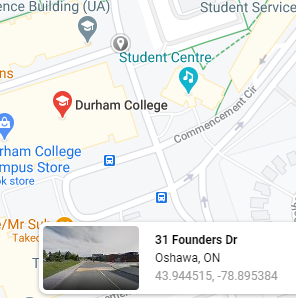

In [40]:
Image(filename='dc.png')

In [9]:
start_point = (43.902926, -78.949285)
end_point = (43.944515, -78.895384)

In [10]:
# get the nearest nodes to the locations 
start_node = ox.get_nearest_node(G, start_point) 
end_node = ox.get_nearest_node(G, end_point)

In [11]:
start_node

1077969015

In [12]:
G[1077969015] #see the information about this node 

AdjacencyView({1077968892: {0: {'osmid': 92992081, 'lanes': '2', 'name': 'Vanier Street', 'highway': 'residential', 'oneway': False, 'length': 85.763}}, 1077968877: {0: {'osmid': 92992056, 'lanes': '2', 'name': 'Robideau Place', 'highway': 'residential', 'oneway': False, 'length': 77.681, 'geometry': <shapely.geometry.linestring.LineString object at 0x000001C31D9947F0>}}, 1050936067: {0: {'osmid': 92992066, 'lanes': '2', 'name': 'Vanier Street', 'highway': 'residential', 'oneway': False, 'length': 102.86, 'geometry': <shapely.geometry.linestring.LineString object at 0x000001C31D994490>}}})

In [13]:
for x in G[1077969015]: #these are the nodes that are attached to this starting node
    print (x)

1077968892
1077968877
1050936067


In [14]:
end_node

2765873189

In [15]:
for x in G[2765873189]: #these are the nodes that are attached to the ending node
    print (x)

1076440552


### Setting up the Q-Learning

In [16]:
def get_list_index(node):
    return nodes_list.index(node)

In [17]:
def get_node (index):
    return nodes_list[index]

In [18]:
# Get list of nodes 
nodes_list = list(G.nodes)

In [19]:
# Create empty rewards matrix
# Matrix will index from 0, so have to use indexes of the nodes_list
R = np.matrix(np.zeros(shape=(num_nodes,num_nodes)))
# Rewards
# Set = 100 if attached to end_node - else = 0
for x in G[end_node]:
    x = get_list_index(x)
    end = get_list_index(end_node)
    R[x,end]=100

In [20]:
R[2950,3653]

100.0

In [21]:
get_list_index(end_node)

3653

In [22]:
# Possible actions 
# Set =-100 if two nodes are not attached - else = 0
Q = np.matrix(np.zeros(shape=(num_nodes,num_nodes)))
Q -= 100
for node in G.nodes:
    for x in G[node]:
        a = nodes_list.index(node)
        b = nodes_list.index(x)
        Q[a,b] = 0
        Q[b,a] = 0

In [23]:
get_list_index(start_node)

3173

In [24]:
get_node(3173)

1077969015

In [25]:
# Find all nodes attached to a node
for x in G[start_node]:
    print(get_list_index(x))

3160
3157
2848


In [26]:
# from start, get the highest Q-value
start = get_list_index(start_node)
sample = np.where(Q[start,] == np.max(Q[start,]))[1]
sample

array([2848, 3157, 3160], dtype=int64)

### Terms:
er - exploration rate (random)

lr - learning rate (The learning rate or step size determines to what extent newly acquired information overrides old information. A factor of 0 makes the agent learn nothing (exclusively exploiting prior knowledge), while a factor of 1 makes the agent consider only the most recent information (ignoring prior knowledge to explore possibilities).

discount factor - (determines the importance of future rewards. A factor of 0 will make the agent "myopic" (or short-sighted) by only considering current rewards, while a factor approaching 1 will make it strive for a long-term high reward)

In [27]:
def next_number(start_index, er):
    # Choose a random number
    random_value = random.uniform(0,1)
    # If it is below the er threshold, next action is chosen randomly
    if random_value < er:
        start = get_node(start_index) # get the node
        sample = G[start] # this will return all nodes attached to start
        sample_list = [] # create list of these indexes 
        for x in G[start_node]:
            sample_list.append(get_list_index(x))
        next_node_index = int(np.random.choice(sample_list,size=1)) # choose one at random
                
    # Else, choose the possible action that has the highest Q value
    # Note - this can return multiple - so choose one at random after
    else:
        sample = np.where(Q[start_index,] == np.max(Q[start_index,]))[1]
        # Select one index at random from sample
        next_node_index = int(np.random.choice(sample,size=1))
    return next_node_index 

In [28]:
def updateQ(node1_index, node2_index, lr, discount):
    # Find the index of the highest Q-value
    max_index = np.where(Q[node2_index,] == np.max(Q[node2_index,]))[1]
    # If there are more than one, choose one at random
    if max_index.shape[0] > 1:
        max_index = int(np.random.choice(max_index, size=1))
    else:
        max_index = int(max_index)
    
    # Get this max Q-value
    max_value = Q[node2_index, max_index]
    
    # Update this Q-value
    Q[node1_index, node2_index] = int((1-lr)*Q[node1_index,node2_index] + lr*(R[node1_index, node2_index] + discount*max_value))

In [29]:
def learn(er, lr, discount, episodes, nodes):
    for i in range(episodes):
        # Choose a random starting location 
        start_index = np.random.randint(0,num_nodes) #this is an index in the list
        next_node_index = next_number(start_index, er)
        updateQ(start_index, next_node_index, lr, discount )

In [30]:
pd.DataFrame(Q)

,0,1,2,3,4,5,6,7,8,9,...,4407,4408,4409,4410,4411,4412,4413,4414,4415,4416
0,-100.0,-100.0,-100.0,-100.0,-100.0,-100.0,-100.0,-100.0,-100.0,-100.0,...,-100.0,-100.0,-100.0,-100.0,-100.0,-100.0,-100.0,-100.0,-100.0,-100.0
1,-100.0,-100.0,-100.0,-100.0,-100.0,-100.0,-100.0,-100.0,-100.0,-100.0,...,-100.0,-100.0,-100.0,-100.0,-100.0,-100.0,-100.0,-100.0,-100.0,-100.0
2,-100.0,-100.0,-100.0,-100.0,-100.0,-100.0,-100.0,-100.0,-100.0,-100.0,...,-100.0,-100.0,-100.0,-100.0,-100.0,-100.0,-100.0,-100.0,-100.0,-100.0
3,-100.0,-100.0,-100.0,-100.0,-100.0,-100.0,-100.0,-100.0,-100.0,-100.0,...,-100.0,-100.0,-100.0,-100.0,-100.0,-100.0,-100.0,-100.0,-100.0,-100.0
4,-100.0,-100.0,-100.0,-100.0,-100.0,-100.0,-100.0,-100.0,-100.0,-100.0,...,-100.0,-100.0,-100.0,-100.0,-100.0,-100.0,-100.0,-100.0,-100.0,-100.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4412,-100.0,-100.0,-100.0,-100.0,-100.0,-100.0,-100.0,-100.0,-100.0,-100.0,...,-100.0,-100.0,0.0,-100.0,0.0,-100.0,0.0,-100.0,-100.0,-100.0
4413,-100.0,-100.0,-100.0,-100.0,-100.0,-100.0,-100.0,-100.0,-100.0,-100.0,...,-100.0,0.0,-100.0,-100.0,-100.0,0.0,-100.0,0.0,-100.0,0.0
4414,-100.0,-100.0,-100.0,-100.0,-100.0,-100.0,-100.0,-100.0,-100.0,-100.0,...,0.0,-100.0,-100.0,-100.0,-100.0,-100.0,0.0,-100.0,-100.0,-100.0
4415,-100.0,-100.0,-100.0,-100.0,-100.0,-100.0,-100.0,-100.0,-100.0,-100.0,...,0.0,0.0,-100.0,-100.0,-100.0,-100.0,-100.0,-100.0,-100.0,-100.0


In [34]:
# Try er = 0.5
# lr = 0.5
# discount = 0.8
# episodes = 50,000
start = time.time()
learn(0.5, 0.5, 0.8, 50000, num_nodes)
end = time.time()
print('{} seconds to learn.'.format(end - start))

8.667824983596802 seconds to learn.


In [35]:
pd.DataFrame(Q)

,0,1,2,3,4,5,6,7,8,9,...,4407,4408,4409,4410,4411,4412,4413,4414,4415,4416
0,-100.0,-100.0,-100.0,-100.0,-100.0,-100.0,-100.0,-100.0,-100.0,-100.0,...,-100.0,-100.0,-100.0,-100.0,-100.0,-100.0,-100.0,-100.0,-100.0,-100.0
1,-100.0,-100.0,-100.0,-100.0,-100.0,-100.0,-100.0,-100.0,-100.0,-100.0,...,-100.0,-100.0,-100.0,-100.0,-100.0,-100.0,-100.0,-100.0,-100.0,-100.0
2,-100.0,-100.0,-100.0,-100.0,-100.0,-100.0,-100.0,-100.0,-100.0,-100.0,...,-100.0,-100.0,-100.0,-100.0,-100.0,-100.0,-100.0,-100.0,-100.0,-100.0
3,-100.0,-100.0,-100.0,-100.0,-100.0,-100.0,-100.0,-100.0,-100.0,-100.0,...,-100.0,-100.0,-100.0,-100.0,-100.0,-100.0,-100.0,-100.0,-100.0,-100.0
4,-100.0,-100.0,-100.0,-100.0,-100.0,-100.0,-100.0,-100.0,-100.0,-100.0,...,-100.0,-100.0,-100.0,-100.0,-100.0,-100.0,-100.0,-100.0,-100.0,-100.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4412,-100.0,-100.0,-100.0,-100.0,-100.0,-100.0,-100.0,-100.0,-100.0,-100.0,...,-100.0,-100.0,0.0,-100.0,0.0,-100.0,0.0,-100.0,-100.0,-100.0
4413,-100.0,-100.0,-100.0,-100.0,-100.0,-100.0,-100.0,-100.0,-100.0,-100.0,...,-100.0,0.0,-100.0,-100.0,-100.0,0.0,-100.0,0.0,-100.0,0.0
4414,-100.0,-100.0,-100.0,-100.0,-100.0,-100.0,-100.0,-100.0,-100.0,-100.0,...,0.0,-100.0,-100.0,-100.0,-100.0,-100.0,0.0,-100.0,-100.0,-100.0
4415,-100.0,-100.0,-100.0,-100.0,-100.0,-100.0,-100.0,-100.0,-100.0,-100.0,...,0.0,0.0,-100.0,-100.0,-100.0,-100.0,-100.0,-100.0,-100.0,-100.0


In [36]:
def shortest_path(begin_index, end_index):
    path=[begin_index]
    print(begin_index)
    # Next node is possible action with highest Q-value
    next_node_index = np.argmax(Q[begin_index,])
    # Add this to path
    path.append(next_node_index)
    print(next_node_index)
    # Continue until you reach the end
    num = 0
    while num < 10 and next_node_index != end_index:
        next_node_index = np.argmax(Q[next_node_index,])
        path.append(next_node_index)
        print(next_node_index)
        num +=1
    return path

In [37]:
begin_index = get_list_index(start_node)
begin_index

3173

In [38]:
end_index = get_list_index(end_node)
end_index

3653

In [39]:
start = time.time()
path = shortest_path(begin_index, end_index)
end = time.time()
print('{} seconds to learn.'.format(end - start))

3173
2848
2635
1277
2253
1220
1619
1220
1619
1220
1619
1220
0.0009980201721191406 seconds to learn.


In [ ]:
####### for now this gets stuck in an infinite loop - that's why i cut it off after 10 steps

In [68]:
# Finding the optimal path 
# this is a built in function that finds shortest paths!
route = nx.shortest_path(G, start_node, end_node, weight = 'length') 
route

[1077969015,
 1050936067,
 1077968886,
 392178970,
 394454438,
 392167544,
 392168518,
 392180372,
 392168202,
 392172596,
 1050800983,
 1077621563,
 1077620906,
 1077620914,
 1077621029,
 1077621338,
 3877460870,
 1077631215,
 1077631196,
 1077631247,
 1077631228,
 1077631233,
 392169423,
 4377213094,
 4377206047,
 4377213099,
 4377213104,
 4377213107,
 392168625,
 3564553395,
 3564553396,
 4592786056,
 4592786055,
 4592786053,
 3250079794,
 3250079798,
 3077238808,
 8177214338,
 8177214336,
 8177214332,
 1076440595,
 1076440513,
 1076440552,
 2765873189]

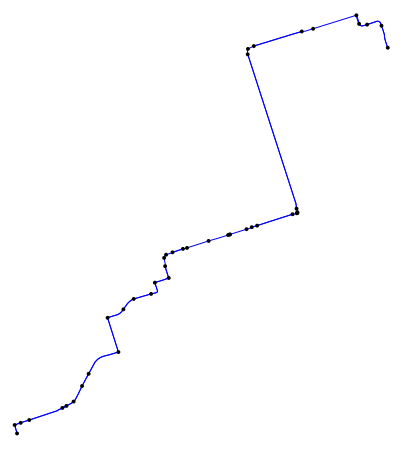

(<Figure size 576x576 with 1 Axes>, <AxesSubplot:>)

In [103]:
k = G.subgraph(route)
ox.plot_graph(k, bgcolor='white', edge_color='blue', node_color='black')

In [41]:
# this can be customized
# if you want to avoid a street, we can remove those nodes and then find the new path

In [76]:
# Say we want to avoid Taunton/Thorton 
# this is the intersection where there is the left turn before going north at the end 

In [104]:
avoid = (43.926932, -78.908327) # need the location

In [105]:
avoid_node = ox.get_nearest_node(G, avoid) # get the closest node
avoid_node

4592786053

In [115]:
G.remove_nodes_from([4592786056,
 4592786055,
 4592786053,3250079794, 3250079798,]) #remove some nodes around this in the route

In [116]:
new_route = nx.shortest_path(G, start_node, end_node, weight = 'length') #find the new path 

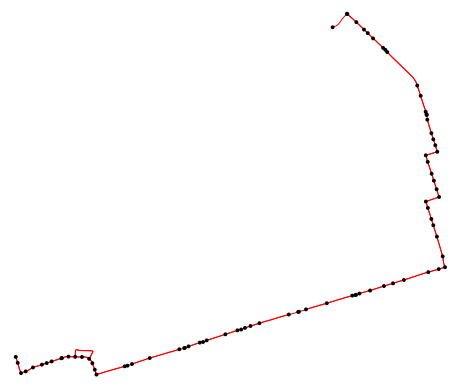

(<Figure size 576x576 with 1 Axes>, <AxesSubplot:>)

In [117]:
k = G.subgraph(new_route)
ox.plot_graph(k, bgcolor='white', edge_color='red', node_color='black')